# Train Convolutional Neural Networks

## Setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

We configure Keras to use CNTK. ELL can only convert CNTK and Darknet models.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "cntk"
import keras.backend as K

Using CNTK backend


Define path to data:

In [3]:
path = "/data/drinks/"

A few basic libraries that we'll need:

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# Use a pretrained VGG model

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

In [5]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=16

In [6]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

In [7]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def compile(model, lr=0.001):
    model.compile(optimizer=Adam(lr=lr),
            loss='categorical_crossentropy', metrics=['accuracy'])

def ft(num):
    model = VGG16(weights='imagenet')
    model.layers.pop()
    for layer in model.layers: layer.trainable=False
    top_model = Sequential()
    top_model.add(Dense(num, activation='softmax', input_shape=model.output_shape[1:]))
    model = Model(inputs = model.input, outputs = top_model(model.output))    
    compile(model)
    return model

def finetune(batches):
    model = ft(batches.num_class)
    classes = list(iter(batches.class_indices))
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    return model, classes

def fit(model, batches, val_batches, epochs=1):
    model.fit_generator(batches,
                            steps_per_epoch=max(1, int(batches.samples/batches.batch_size)),
                             epochs=epochs,
                             validation_data=val_batches,
                             validation_steps=max(1, int(val_batches.samples/val_batches.batch_size))
                       )

# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)
model, classes = finetune(batches)
fit(model, batches, val_batches, epochs=1)
model.save_weights(path + 'my_weights.h5')

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Epoch 1/1
35/35 [==============================] - 44s - loss: 1.0216 - acc: 0.9304 - val_loss: 0.9816 - val_acc: 1.0000

Now that our model is trained, we can visualize the predictions on some of the images:

Found 141 images belonging to 3 classes.


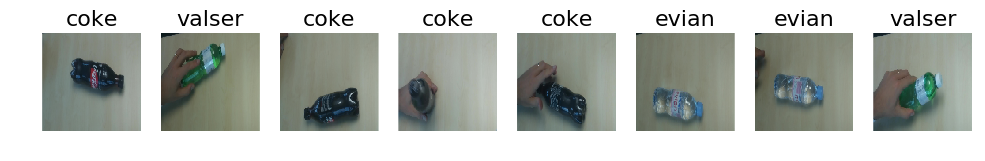

In [9]:
def predict(model, classes, imgs):
    all_preds = model.predict(imgs)
    idxs = np.argmax(all_preds, axis=1)
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    classes = [classes[idx] for idx in idxs]
    return np.array(preds), idxs, classes

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=(12,6))
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs,labels = next(get_batches(path+'valid'))
pred = predict(model, classes, imgs)
plots(imgs, titles = pred[2])

Now we save our model in CNTK format to use in ELL:

In [11]:
import cntk
cntk.combine(model.outputs).save('drinks.model')